In [2]:
#importing libraries
import os
import gzip
import random
import datetime
import time
from itertools import product 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"

# **Q2 Logistic Regression**

In [3]:
## Script 2

# One-hot encoding of the labels
def one_hot_encoding(label_data):
    encoded_labels = np.zeros((len(label_data), 10)) # TODO: Write this function by yourself
    for i in range(len(label_data)):
        encoded_labels[i][label_data[i]] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data
    rows = normalized_pixels.shape[0]//784
    flattened_pixels = normalized_pixels.reshape(rows,784) # TODO: Flatten the normalized pixels
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("data/train-images-idx3-ubyte.gz")
    y_train = read_labels("data/train-labels-idx1-ubyte.gz")
    X_test = read_pixels("data/t10k-images-idx3-ubyte.gz")
    y_test = read_labels("data/t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test

class StandardScaler():
    # StandardScaler Class written from scratch similar to sklearn.preprocessing.StandardScaler
    def __init__(self):
        pass
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X - self.mean_, axis=0)
        if np.any(self.scale_ == 0):
            self.scale_ = np.where(self.scale_ == 0, 1, self.scale_)
        return self
    def transform(self, X):
        return (X - self.mean_) / self.scale_
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
X_train, y_train, X_test, y_test = read_dataset()
X_val = X_train[:10000]
y_val = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]

# # Scale data using StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

X_train /= 255
X_val /= 255
X_test /= 255

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

# For Question 2.4
# Code to visualize weights (use your own weight variable, adjust its shape by yourself)
#plt.matshow(weight, cmap=plt.cm.gray, vmin=0.5*weight.min(), vmax=0.5*weight.max())

((50000, 784),
 (50000, 10),
 (10000, 784),
 (10000, 10),
 (10000, 784),
 (10000, 10))

In [34]:
class LogisticRegression():
    # Logistic Regression Model written from scratch without Bias w0
    def __init__(self, seed=42):
        np.random.seed(seed)
        self.W = None
        self.now = None
        self.print_result = True
        self.history = None
        self.validation_accuracy = None
        
    def validation_accuracy(self):
        return self.validation_accuracy
    
    def history(self):
        return self.history
    
    def load_history(self):
        pd_hist = pd.read_csv(f'model-comparison/{self.now}/history.csv')
        self.history = np.array(pd_hist.iloc[:,1:])
        
    def plot(self, save = True):
        # Save history as csv file
        history_local = self.history
        if type(history_local) is not pd.DataFrame:
            history_df = pd.DataFrame(history_local)
        if save == True:
            hist_csv_file = f'model-comparison/{self.now}/history.csv'
            with open(hist_csv_file, mode='w') as f:
                history_df.to_csv(f) 
        # Plot Loss and Accuracy History as Subplots
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(10, 2)
        index = np.arange(1,self.history.shape[1]+1)*10

        ax[0].plot(index, self.history[0], label='Training Loss')
        ax[0].plot(index, self.history[2], label='Validation Loss')
        ax[0].set_title('Loss History')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        ax[1].plot(index, self.history[1], label='Training Accuracy')
        ax[1].plot(index, self.history[3], label='Validation Accuracy')
        ax[1].set_title('Accuracy History')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        if save is True and self.now is not None:
            plt.savefig(f'model-comparison/{self.now}/plot.png')
        if self.print_result == True:
            plt.show()
        else:
            plt.close(fig)
        
    
    def validation(self, X_nonbiased, y, W, lmbda):
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        # Find loss and accuracy on validation set
        y_onehot = y # y is already one-hot encoded
        Z = - X @ W
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        loss = - np.sum(y_onehot * np.log(P)) + lmbda * np.sum(W**2)
        y_pred = self.predict(X_nonbiased)
        accuracy = np.mean(y_pred == np.argmax(y, axis=1))
        return loss, accuracy
    
    def fit(self, X_nonbiased, y, X_val, y_val, now = None, print_result = True,max_epoch=400, batch_size=50000, weight_init='zero', lr=0.01, lr_type = 'static', regularization='l2: 0.01'):
        start_time = datetime.datetime.now()
        # if there isn't model-comparison folder, create it
        if not os.path.exists('model-comparison'):
            os.mkdir('model-comparison')
        self.print_result = print_result
        if now is not None:
            self.now = now
        # Create folder for current model
            os.mkdir('model-comparison/'+now)
        
        self.history = np.zeros((4,max_epoch//10))
        y_onehot = y # y is already one-hot encoded
        lr_print = str(lr) + ' ' + lr_type
        model_specs = 'Logistic Regression | Batch Size: {} | Weight Init. {} | lr: {} | Regularization: {} | Max Epoch: {} |'.format(batch_size, weight_init, lr_print, regularization, max_epoch)
        
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        
        # Initialize weights ( shape = features x classes matrix )
        if weight_init == 'zero':
            self.W = np.zeros((X.shape[1], y_onehot.shape[1])) 
        elif weight_init == 'uniform':
            self.W = np.random.uniform(0, 1, (X.shape[1], y_onehot.shape[1]))
        elif weight_init == 'normal':
            self.W = np.random.normal(0, 1, (X.shape[1], y_onehot.shape[1]))
        
        # Print loss and accuracy every 100 iterations or every max_iter//10 iterations if max_iter >= 1000
        print_step = 10
        if max_epoch >= 1000:
            print_step = max_epoch // 10

        # Gradient Descent
        for epoch in range(1, max_epoch+1):
            for iteration in range(X.shape[0]//batch_size):                                        
                X_batch = X[batch_size*iteration:batch_size*(iteration+1)]
                y_batch = y_onehot[batch_size*iteration:batch_size*(iteration+1)]
                Z_batch = - X_batch @ self.W
                # For numerical stability
                ### Z_batch = Z_batch - np.max(Z_batch, axis=1, keepdims=True)
                # Logistic function to find probabilities
                P_batch = np.exp(Z_batch) / (np.sum(np.exp(Z_batch), axis=1, keepdims=True))
                # Number of X instances
                N = X_batch.shape[0]
                # Derivative of Residual ( log-loss )
                dRSS = (X_batch.T @ (y_batch - P_batch))
                # Choose regularization
                if regularization[0:2] == 'l2':
                    # L2 regularization
                    lmbda = float(regularization[4:])
                    dRegTerm = lmbda * self.W
                elif regularization[0:2] == 'l1':
                    # L1 regularization
                    lmbda = float(regularization[4:])
                    dRegTerm = lmbda * np.sign(self.W) 
                else:
                    # No regularization
                    lmbda = 0
                    dRegTerm = 0
                # Calculate gradient
                gradient = dRSS + dRegTerm
            
                if lr_type[0:8] == 'momentum':
                    if epoch == 1:
                        last_gradient = gradient
                    else:
                        momentum = float(lr_type[10:])
                        gradient = gradient + momentum * last_gradient
                        last_gradient = gradient
                    
                # Update weights
                self.W = self.W - lr * gradient
            
                # Change learning rate if lr_type is adaptive
                if lr_type == 'adaptive':
                    if epoch % 300 == 0:                    
                        lr = lr * 2
                        if print_result == True:
                            print('Learning rate changed to', lr)
            # After each epoch, calculate loss and accuracy on validation set
            Z = - X @ self.W
            # Numerical stability
            ### Z = Z - np.max(Z, axis=1, keepdims=True)
            P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

            # Calculate loss and accuracy every 10 epochs:
            if epoch % 1 == 0:
                loss = - np.sum(y_onehot * np.log(P)) + lmbda * np.sum(self.W**2)
                accuracy = np.mean(self.predict(X_nonbiased) == np.argmax(y, axis=1))
                val_loss = self.validation(X_val, y_val, self.W, lmbda)[0]
                val_acc = self.validation(X_val, y_val, self.W, lmbda)[1]
                self.validation_accuracy = val_acc
                self.history[:,(epoch//10)-1] = np.array([loss, accuracy, val_loss, val_acc])
                
                # Print loss and accuracy every 100 epochs
                if epoch % print_step == 0:
                    line1 = 'Epoch: ' + str(epoch)
                    line2 = ' | Loss: ' + str(loss) + ' | Accuracy: ' + str(accuracy)[0:5]
                    line3 = ' | Val. Loss: ' + str(val_loss) + ' | Val. Acc: ' + str(val_acc)[0:5]
                    # line2 = ' | Loss: ' + str(round(loss)) + ' | Accuracy: ' + str(accuracy)[0:5]
                    # line3 = ' | Val. Loss: ' + str(round(val_loss)) + ' | Val. Acc: ' + str(val_acc)[0:5]
                    if print_result == True:
                        print(line1 + line2 + line3)
                    if now is not None:
                        with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                            f.write(line1 + line2 + line3 + '\n')
            if epoch == max_epoch:
                end_time = datetime.datetime.now()
                if print_result == True:
                    print('Training finished. Time elapsed:', end_time - start_time, '\n')
                    print('Accuracy: ', str(accuracy)[0:5], 'Val. Accuracy: ', str(val_acc)[0:5])
                val_acc_print = str(val_acc*100)+ '00'
                if now is not None:
                    with open('model-comparison/{}/log.txt'.format(now), 'a') as f:
                        write_line = 'Training finished. Time elapsed: ' + str(end_time - start_time) + '\n'
                        f.write(write_line)
                    with open('model-comparison/{}/{}-val-acc.txt'.format(now,val_acc_print[0:5]), 'w') as f:
                        f.write(model_specs)
                    with open('model-comparison/last.txt', 'w') as f:
                        f.write(str(now))
                
    def predict(self, X_nonbiased):
        # add bias
        ones=np.ones(X_nonbiased.shape[0])
        X=np.c_[ones,X_nonbiased]
        Z = - X @ self.W
        # Logistic function to find probabilities
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        # Predict class
        y = np.argmax(P, axis=1)
        return y
    def save_weights(self):
        filename = 'model-comparison/{}/weights.npy'.format(self.now)
        np.save(filename, self.W)
    def load_weights(self, now):
        filename = 'model-comparison/{}/weights.npy'.format(now)
        self.W = np.load(filename)
        self.now = now

In [5]:
class EvaluateModel():
    # Class to evaluate model performance, similar to sklearn.metrics ClassificationReport and ConfusionMatrix
    def __init__(self, y_true, y_pred, str1, now, save=True, print_result=True):
        self.y_true = np.argmax(y_true, axis=1)
        self.y_pred = y_pred
        if save == True:
            os.mkdir('model-comparison/'+now+'/'+str1)
            np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
        
        result = self.classification_report()
        fpr0 = 100 - float(result['precision'][0][0:4])
        line1 = 'Accuracy is: ' + str(result['f1-score']['accuracy'])
        line2 = 'F1 Score is: ' + str(result['f1-score']['weighted avg'])
        line3 = 'Precision of Class 0 is: ' + '{0:.2f}'.format(100-fpr0)+ ' %'
        line4 = '\nClassification Report:'
        line5 = '\nConfusion Matrix:'
        cm = self.confusion_matrix()
        line6 = '\n'
        res_total = line1 + '\n' + line2 + '\n' + line3 + '\n' + line4 + '\n' + str(result) + '\n' + line5 + '\n' + str(cm) + '\n' + line6
        # write to file
        if save == True:
            with open('model-comparison/{}/{}/report.txt'.format(now,str1), 'w') as f:
                f.write(res_total)
        if print_result == True:
            print(res_total)

    def accuracy_score(self, y_t, y_p):
        correct = sum(y_t == y_p)
        return correct / len(y_t)

    def scores(self, y_t, y_p, class_label= 1):
        true = y_t == class_label
        pred = y_p == class_label
        tp = sum(true & pred)
        fp = sum(~true & pred) 
        fn = sum(true & ~pred)
        tn = sum(~true & ~pred) 
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        return precision, recall, f1
    
    def confusion_matrix(self,labels=None):
        labels = labels if labels else sorted(set(self.y_true) | set(self.y_pred))        
        indexes = {v:i for i, v in enumerate(labels)}
        matrix = np.zeros((len(indexes),len(indexes))).astype(int)
        for t, p in zip(self.y_true, self.y_pred):
            matrix[indexes[t], indexes[p]] += 1
        # print('Confusion Matrix: ')
        # print(pd.DataFrame(matrix, index=labels, columns=labels))
        return pd.DataFrame(matrix, index=labels, columns=labels)

    def classification_report(self):
        output_dict = {}
        support_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        for i in np.unique(self.y_true):
            support = sum(self.y_true == i)
            precision, recall, f1 = self.scores(self.y_true, self.y_pred, class_label=i)
            output_dict[i] = {'precision':precision, 'recall':recall, 'f1-score':f1, 'support':support}
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            support_list.append(support)
        support = np.sum(support_list)
        output_dict['accuracy'] = {'precision':0, 'recall':0, 'f1-score':self.accuracy_score(self.y_true, self.y_pred), 'support':support}
        # macro avg
        macro_precision = np.mean(precision_list)
        macro_recall = np.mean(recall_list)
        macro_f1 = np.mean(f1_list)
        output_dict['macro avg'] = {'precision':macro_precision, 'recall':macro_recall, 'f1-score':macro_f1, 'support':support}
        # weighted avg
        weighted_precision = np.average(precision_list, weights=support_list)
        weighted_recall = np.average(recall_list, weights=support_list)
        weighted_f1 = np.average(f1_list, weights=support_list)
        output_dict['weighted avg'] = {'precision':weighted_precision, 'recall':weighted_recall, 'f1-score':weighted_f1, 'support':support}
        # convert to dataframe and format
        report_d = pd.DataFrame(output_dict).T
        annot = report_d.copy()
        annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
        annot['support'] = annot['support'].astype(int)
        annot.loc['accuracy','precision'] = ''
        annot.loc['accuracy','recall'] = ''
        return annot

Epoch: 10 | Loss: 26768.046741908947 | Accuracy: 0.876 | Val. Loss: 5562.615186554703 | Val. Acc: 0.876
Epoch: 20 | Loss: 21578.101779372657 | Accuracy: 0.893 | Val. Loss: 4629.175284428988 | Val. Acc: 0.891
Epoch: 30 | Loss: 19145.48441991109 | Accuracy: 0.901 | Val. Loss: 4194.623946501256 | Val. Acc: 0.898
Epoch: 40 | Loss: 17653.23172072383 | Accuracy: 0.907 | Val. Loss: 3929.516306827207 | Val. Acc: 0.904
Epoch: 50 | Loss: 16627.72732575718 | Accuracy: 0.911 | Val. Loss: 3748.5395759790304 | Val. Acc: 0.906
Epoch: 60 | Loss: 15873.692972724135 | Accuracy: 0.914 | Val. Loss: 3616.6098928421848 | Val. Acc: 0.907
Epoch: 70 | Loss: 15293.42118851206 | Accuracy: 0.917 | Val. Loss: 3516.161218264255 | Val. Acc: 0.908
Epoch: 80 | Loss: 14831.861394015217 | Accuracy: 0.919 | Val. Loss: 3437.2655889251114 | Val. Acc: 0.909
Epoch: 90 | Loss: 14455.316795266115 | Accuracy: 0.921 | Val. Loss: 3373.8083035566615 | Val. Acc: 0.910
Epoch: 100 | Loss: 14141.86880358621 | Accuracy: 0.922 | Val. Lo

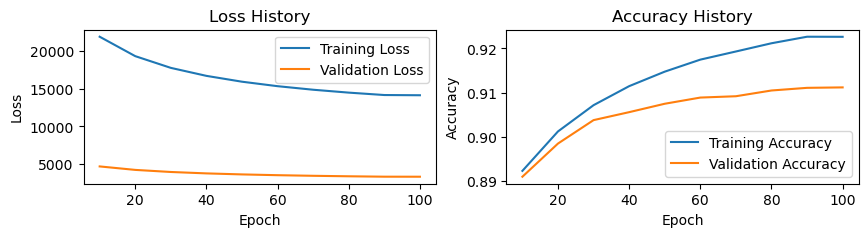

In [19]:
# Train new model
now = datetime.datetime.now().strftime("%d-%m-%H-%M")

# Fit model 
model = LogisticRegression(seed=42)
model.fit(X_train, y_train, X_val, y_val, now, max_epoch=100, 
          batch_size=200, weight_init='normal', lr=0.0005, lr_type='static', regularization='l2: 0.0001')
model.save_weights()
model.plot()



In [ ]:
# # Validation Set Results
# y_pred = model.predict(X_val)
# results = EvaluateModel(y_val, y_pred, 'val', now)

# # Test Set Results
# y_pred = model.predict(X_test)
# results = EvaluateModel(y_test, y_pred, 'test', now)

In [29]:
# Grid Search Combinations
default = [100, 'normal', 200, 0.0005, 'static', 'l2: 0.0001']
max_epoch = [100]
weight_init = ['zero', 'uniform', 'normal']
batch_size = [1, 64, 50000]
lr = [0.1, 0.001, 0.0001, 0.00001]
lr_type = ['static']
regularization = ['l2: 0.01','l2: 0.0001', 'l1: 0.000000001']
params = [max_epoch, weight_init, batch_size, lr, lr_type, regularization]
total_options = [tuple(default.copy())]
print('For Default Model:', 'Number of combinations:', len(total_options))
print(total_options[0])
for i in range(len(default)):
    default[i] = [default[i]]
for i in range(len(default)):
    if len(params[i]) != 1:
        params1 = default.copy()
        params1[i] = params[i]
        model_options1 = list(product(*params1))
        print('\nFor parameter:', params[i], 'Number of combinations:', len(model_options1))
        for j in model_options1:
            print(j)
        total_options += model_options1
print('\n', 'Total Number of combinations:', len(total_options))

For Default Model: Number of combinations: 1
(100, 'normal', 200, 0.0005, 'static', 'l2: 0.0001')

For parameter: ['zero', 'uniform', 'normal'] Number of combinations: 3
(100, 'zero', 200, 0.0005, 'static', 'l2: 0.0001')
(100, 'uniform', 200, 0.0005, 'static', 'l2: 0.0001')
(100, 'normal', 200, 0.0005, 'static', 'l2: 0.0001')

For parameter: [1, 64, 50000] Number of combinations: 3
(100, 'normal', 1, 0.0005, 'static', 'l2: 0.0001')
(100, 'normal', 64, 0.0005, 'static', 'l2: 0.0001')
(100, 'normal', 50000, 0.0005, 'static', 'l2: 0.0001')

For parameter: [0.1, 0.001, 0.0001, 1e-05] Number of combinations: 4
(100, 'normal', 200, 0.1, 'static', 'l2: 0.0001')
(100, 'normal', 200, 0.001, 'static', 'l2: 0.0001')
(100, 'normal', 200, 0.0001, 'static', 'l2: 0.0001')
(100, 'normal', 200, 1e-05, 'static', 'l2: 0.0001')

For parameter: ['l2: 0.01', 'l2: 0.0001', 'l1: 0.000000001'] Number of combinations: 3
(100, 'normal', 200, 0.0005, 'static', 'l2: 0.01')
(100, 'normal', 200, 0.0005, 'static', 'l

In [36]:
def GridSearch(model_options, X_train, y_train, X_val, y_val, X_test, y_test):
    # Grid Search Function
    best_metric = 0
    for i in range(len(model_options)):
        models = model_options[i]
        model_number = i + 1
        now = datetime.datetime.now().strftime("%d-%m-%H-%M")
        model = LogisticRegression()
        start_time = datetime.datetime.now()
        model.fit(X_train, y_train, X_val, y_val, now, print_result=False, max_epoch=models[0], 
                  weight_init= models[1], batch_size=models[2], lr=models[3], lr_type=models[4], regularization=models[5])
        metric = model.validation_accuracy
        model.save_weights()
        model.plot()
        y_pred = model.predict(X_val)
        results = EvaluateModel(y_val, y_pred, 'val', now, print_result=False)
        y_pred = model.predict(X_test)
        results = EvaluateModel(y_test, y_pred, 'test', now, print_result=False)
        if metric > best_metric:
            best_metric = metric
            best_model = now
        print('Model ', str(model_number), ' saved with name: ', now)
        print(models, 'Val-Accuracy:', metric)
        end_time = datetime.datetime.now()
        time_elapsed = str(end_time - start_time)[2:7]
        if end_time.minute-start_time.minute < 1:
            if end_time.second-start_time.second < 60:
                x = abs(61-end_time.second-start_time.second)
                time.sleep(x)
            else :
                time.sleep(60)
        # append to txt file
        model_specs = 'Logistic Regression | Batch Size: {} | Weight Init: {} | lr: {} | Regularization: {} | Max Epoch: {}'.format(models[2], models[1], models[3], models[5], models[0])
        with open('model-comparison/best-models.txt', 'a') as f:
            f.write(now + ' | ' + model_specs + ' | ' + str(metric) + ' | Time Elapsed: '+ time_elapsed +'\n')
        print(len(model_options)-model_number, 'models left to train.')
    best_metric = str(best_metric*100)[:5]
    print('Best Model is:', best_model, 'with validation accuracy:', best_metric, '%')

In [50]:
best_model = [(100, 'uniform', 1, 0.0005, 'static', 'l2: 0.0001')]
GridSearch(model_options1, X_train, y_train, X_val, y_val, X_test, y_test)
os.system(finish_sound)

Model  1  saved with name:  12-12-16-33
(100, 'uniform', 1, 0.0005, 'static', 'l2: 0.0001') Val-Accuracy: 0.9226
0 models left to train.
Best Model is: 12-12-16-33 with validation accuracy: 92.25 %


0

In [53]:
# Grid Search Combinations
default = [100, 'normal', 200, 0.0005, 'static', 'l2: 0.0001']
max_epoch = [100]
weight_init = ['zero', 'uniform', 'normal']
batch_size = [1] # [1, 64, 50000]
lr = [0.1, 0.001, 0.0001, 0.0005, 0.00001]
lr_type = ['static']
regularization = ['l2: 0.01','l2: 0.0001', 'l1: 0.000000001']
params = [max_epoch, weight_init, batch_size, lr, lr_type, regularization]
model_options2 = list(product(*params))
print('Number of combinations:', len(model_options2))

Number of combinations: 45


In [ ]:

GridSearch(model_options2, X_train, y_train, X_val, y_val, X_test, y_test)
os.system(finish_sound)